# House Prices: Advanced Regression Techniques (Kaggle)

## 09-

Sources:
* Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
* Check missing values (Will Koehrsen): https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction by Will Koehrsen
* Neural net implementation in PyTorch with embeddings (Yashu Seth): https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/ 
* Neural network embeddings explained (Will Koehrsen) https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526
* Sklearn pipelines: https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62
* Pipelines with dataframes (John Ramey): https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/


## Problem description

**Previous**:

**kaggle-houseprice-01-linear-model-and-continuous-imputation.ipynb**
We try to predict house prices based on a number of continuous and categorical variables.
In the first step, the prediction will be made using only a small selection of continuous variables:

* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* TotalBsmtSF: Total square feet of basement area
* SalePrice: target variable

We will use a very simple network: a linear network with a single non-linearity.

**kaggle-houseprice-02-data-scaling.ipynb**

In order to make it a little easier for gradient descent to converge to a minimum, we will scale the input data to have 0 mean and a standard deviation of 1. For a discussion on why it is useful to scale input data, see https://stats.stackexchange.com/questions/249378/is-scaling-data-0-1-necessary-when-batch-normalization-is-used. We will not scale the target data, following this discussion: https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re.

**kaggle-houseprice-03-one-hot-for-missing-continuous.ipynb**

Instead of just replacing missing values in our dataset with the mean or the median of the respective column, we will now create a *one-hot encoded vector* to mark the previously *missing data* and add it to the data set. For the same reason that we used the *sklearn.preprocessing StandardScaler* we will now make use of the *sklearn.impute Imputer* to replace missing values. Also, to make this part of data processing a little easier to reuse, we will refactor the code into a function. 

* missing_LotFrontage: one-hot vector with 1 for each missing value in LotFrontage and 0 else

**kaggle-houseprice-04-pipeline-for-preprocessing.ipynb**

Instead of relying on self-written code for processing our continuous variables we will now delegate this part of the processing to sklearn transformers. Additionally, those transformers will be put in a pipeline so that the transformers don't have to be called individually every time. This will help keeping our code simple and clean, and produce consistent results for processing multiple data.

* Add categorical variables
* Extend pipeline to handle categoricals
* Create a function to pre-process an arbitrary amount of dataframes at once

**kaggle-houseprice-05-adding-categorical-variables.ipynb**

We still need to add more data to our model. In contrast to the first set of continuous variables, this time we will add categorical variables. Categorical variables differ from continuous variables in the fact that there may or may not be a natural order to values of a categorical variable, and that we cannot use categorical variables to do meaningful calculations (e.g. to calculate the mean, or a sum). For more information see https://en.wikipedia.org/wiki/Level_of_measurement.
Often those variables are represented by strings. In order to let our network handle categorical variables, we need to convert them to numbers (also called *factors* or *codes*). Additionally, we will expand our pre-processing pipeline to also handle missing values for categorical variables. We will also create a function that let's us use the pipeline on an arbitrary amount of dataframes at the same time.

New variables:
* MSZoning: Identifies the general zoning classification of the sale.
* MSSubClass: Identifies the type of dwelling involved in the sale.

**kaggle-houseprice-06-categoricals-and-embeddings-in-the-neural-net.ipynb**

In order to make proper use of categorical variables in a neural net we also implement embedding layers.
The advantage of embedding layers compared to one-hot encoding is that first they provide the possibility of a richer representation of values of a categorical variable. This means that for example in an embedded layer representation of weekdays, the neural net can find a relationship between days of a weekend vs days during the week, which is not possible with one-hot encoding. The second advantage is that using embedding layers has generally less memory requirements compared to a one-hot encoding representation. The embedding layers simply serve as a lookup-matrix. The lookup index for the matrix is the actual value of the categorical variable for each observation. This representation generally requires less memory than a one-hot encoding equivalent. For further explanation see sources above.

**kaggle-houseprice-07-validation-set-all-features-kaggle.ipynb**

Since the first pre-processing steps are implemented, we can now add all remaining data into our model that we haven't used so far. In order to also get some idea about the performance of the model so far, we want to upload our results to the kaggle website. We will adjust our loss function to the one that is required in the kaggle competition: root mean squared log error, which just requires a small modification to the loss function that we have been using so far.
But because we don't want to upload every single set of predictions to kaggle to see how we are doing, we will also split the training data to get a validation set. We will then evaluate the validation loss which plays in important part in further tuning the data and the model.

**Now:**

Add more layers, add dropout layers.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, QuantileTransformer

In [2]:
# Show more rows and columns in the pandas output
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Helpers

In [4]:
def show_missing(df, show_all=True):
    """    
    Shows absolute and relative number of missing values for each column of a dataframe,
    show_all=True also shows columns with no missing values.
    """
    mis_val_abs = df.isnull().sum()
    mis_val_rel = df.isnull().sum()/df.shape[0]
    mis_val_table = pd.concat([df.dtypes, mis_val_abs, mis_val_rel], axis=1)
    mis_val_table = mis_val_table.rename(columns={0: 'dtype', 1: 'Missing abs', 2: 'Missing rel'})

    if show_all:
        # Sort table descending by relative amount missing
        mis_val_table = mis_val_table.sort_values('Missing rel', ascending=False).round(3)
    else:
        # Sort table descending by relative amount missing, remove columns where no values are missing
        mis_val_table = mis_val_table[mis_val_table.iloc[:, 1] != 0].sort_values('Missing rel', ascending=False).round(3)
    
    return mis_val_table

In [5]:
# The TypeSelector selects data from a dataframe based on its dtype. Credits to John Ramey, see sources on top.
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype=dtype
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])        

In [6]:
def proc_df(cont_names, cat_names, *dataframes):
    """
    Pre-process arbitrary amount of dataframes with continuous and categorical variables.
    The respective fits are being calculated by combining all dataframes into a single
    dataframe.
    Returns one processed dataframe for each input dataframe.
    
    Parameters
    ----------
    cont_names : list
        List of column names for continuous variables.

    cat_names : list
        List of column names for categorical variables.

    *dataframes : pandas DataFrame(s)
        DataFrames to be processed.
    """
    
    df_combo = pd.DataFrame(columns=dataframes[0].columns)
    for arg in dataframes:
        df_combo = pd.concat([df_combo, arg], axis=0, sort=False)
        arg[cont_names] = arg[cont_names].astype('float64')
        arg[cat_names] = arg[cat_names].astype('category')
    
    # Convert columns in cont_names to *float64* dtype and the columns of cat_names to *category*.
    # This is necessary so that the TypeSelector in the pipeline can differentiate between cont and cat variables.
    # The pipeline can then apply different behaviour, according to the dtype.
    df_combo[cont_names] = df_combo[cont_names].astype('float64')
    df_combo[cat_names] = df_combo[cat_names].astype('category')
    
    # First, get names of columns with missing values.
    # The pipeline below then takes numeric features, in the order of appearance in the input dataframe.
    # The pipeline then takes categorical features in the order of appearance in the input dataframe.
    # All of these names are then merged to a list, and for the resulting dataframes.
    # This naming step is necessary because sklearn does not natively support pandas dataframes, and therefore
    #   all column names would be lost otherwise.
    missing_names = [f'mis_{name}' for name in df_combo.columns if df_combo[name].isnull().any()]
    ordered_cont_names = [col for col in df_combo.columns if col in cont_names]
    ordered_cat_names = [col for col in df_combo.columns if col in cat_names]
    names = missing_names + ordered_cont_names + ordered_cat_names
    
    preprocessing_pipeline = make_pipeline(
        FeatureUnion(transformer_list=[
            ('missing_features', make_pipeline(
                MissingIndicator(missing_values=np.nan)
            )),
            ('numeric_features', make_pipeline(
                TypeSelector('float64'),
                SimpleImputer(strategy='median'),
                # StandardScaler()
                QuantileTransformer()
            )),
            ('categorical_features', make_pipeline(
                TypeSelector('category'),
                SimpleImputer(strategy='most_frequent'),
                OrdinalEncoder()
            ))
        ])
    )
    preprocessing_pipeline.fit(df_combo)
        
    return (pd.DataFrame(preprocessing_pipeline.transform(arg), columns=names) for arg in dataframes)

In [7]:
def get_emb_dims(df):
    """
    Returns a list of tuples of the number of factors of a categorical
    variable and the minimum of half that number of factors + 1, and 50.
    
    Parameters
    ----------
    df : pandas.DataFrame
    """
    return [(df[name].nunique(), min(50, (df[name].nunique()+1)//2)) for name in df.columns]

## Load data

In [8]:
PATH = Path('../data/houseprice/')
#!dir {PATH}  # For Windows
!ls {PATH}

data_description.txt  sample_submission.csv  test.csv	train_tiny.csv
models		      submission.csv	     train.csv


In [9]:
# Import training data
df_train = pd.read_csv(PATH/'train.csv', sep=',', header=0)

In [10]:
dep = ['SalePrice']
df_train_y = df_train[dep]
df_train.drop(dep, axis=1, inplace=True)

In [11]:
df_test = pd.read_csv(PATH/'test.csv', sep=',', header=0)

In [12]:
cat_names = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
             'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
             'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
             'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'Heating',
             'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
             'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
             'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

In [13]:
cont_names = [name for name in df_train.columns if name not in cat_names]

## Pre-processing

In [14]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [15]:
df_train[cont_names].describe()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041
std,421.610009,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024
min,1.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.750000,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,730.500000,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1095.250000,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1460.000000,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


In [16]:
# Categorical variables can be of type int or string. To show all cat columns in describe,
# we need to convert them to the same dtype
df_train[cat_names].astype('category').describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,770,1379,1379.0,1379,1460,1379,1379,1460,7,281,54,1460,1460,1460,1460
unique,15,5,2,2,4,4,2,5,3,25,9,8,5,8,10,9,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,3,4,3,8,4,4,12,7,4,5,6,97.0,3,5,5,5,3,3,4,4,12,5,9,6
top,20,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,0,0,2,0,3,1,TA,6,Typ,0,Gd,Attchd,2005.0,Unf,2,TA,TA,Y,Gd,MnPrv,Shed,6,2009,WD,Normal
freq,536,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,397,821,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,856,1378,768,913,804,1392,735,402,1360,690,380,870,65.0,605,824,1311,1326,1340,3,157,49,253,338,1267,1198


In [17]:
pd.concat([show_missing(df_train), show_missing(df_test)], axis=1, sort=False)

,dtype,Missing abs,Missing rel,dtype,Missing abs,Missing rel
PoolQC,object,1453,0.995,object,1456,0.998
MiscFeature,object,1406,0.963,object,1408,0.965
Alley,object,1369,0.938,object,1352,0.927
Fence,object,1179,0.808,object,1169,0.801
FireplaceQu,object,690,0.473,object,730,0.500
LotFrontage,float64,259,0.177,float64,227,0.156
GarageType,object,81,0.055,object,76,0.052
GarageYrBlt,float64,81,0.055,float64,78,0.053
GarageQual,object,81,0.055,object,78,0.053
GarageCond,object,81,0.055,object,78,0.053


In [18]:
df_train, df_test = proc_df(cont_names, cat_names, df_train, df_test)

In [19]:
# Redefine cat_names to include the new missing value columns
cat_names = [col for col in list(df_train.columns) if col not in cont_names]

# PyTorch

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

## Dataset, dataloader

In order to make the categorial variables distinct from the continuous variables when they're being used in the model, we will now split categorical and continuous variables for the training dataset.

Further, categorical variables will take the datatype torch.long, as opposed to torch.float32 for continuous variables.

In [22]:
num_train = 1095

In [23]:
# Convert all training data containers to tensors
t_train_cat = torch.tensor(df_train[:num_train][cat_names].values, dtype=torch.long, device=device)
t_train_cont = torch.tensor(df_train[:num_train][cont_names].values, dtype=torch.float32, device=device)
t_train_y = torch.tensor(df_train_y.values[:num_train], dtype=torch.float32, device=device)

# Convert all validation data containers to tensors
t_val_cat = torch.tensor(df_train[num_train:][cat_names].values, dtype=torch.long, device=device)
t_val_cont = torch.tensor(df_train[num_train:][cont_names].values, dtype=torch.float32, device=device)
t_val_y = torch.tensor(df_train_y.values[num_train:], dtype=torch.float32, device=device)

In [24]:
# Dataset
train_ds = TensorDataset(t_train_cat, t_train_cont, t_train_y)

In [25]:
# Dataloader
batch_size=128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

## Loss

Because we are going to submit our results to kaggle, we should also use the performance metric that is required for this competition:

In [26]:
def rmsle(x, y):
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
    
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return torch.sqrt( ((torch.log(x + 1) - torch.log(y + 1))**2).mean() )

In [27]:
# loss_fn = F.mse_loss
loss_fn = rmsle

## Model

### New

Taking a look at the training and validation loss in the last notebook, we could observe that at some point the validation loss was not improving anymore. Even worse, it went up. This can be a sign of overfitting. In order to reduce overfitting we will add a dropout layer to our network.

In [54]:
class LinearNet(nn.Module):
    def __init__(self, emb_dims, num_cont, p_dropout=0.5):
        super().__init__()        
        """
        Parameters
        ----------
        emb_dims : List of two element tuples
            This list will contain a two element tuple for each
            categorical feature. The first element of a tuple will
            denote the number of unique values of the categorical
            feature. The second element will denote the embedding
            dimension to be used for that feature.
        
        num_cont : Integer
            Number of continuous variables.
        
        dropout : Float
            Dropout probability applied after first linear layer.
        """
        
        self.num_cont = num_cont
        self.num_embeddings = sum([d for f, d in emb_dims])
        self.num_features = self.num_embeddings + self.num_cont
        self.p_dropout = p_dropout
        
        # Embedding layers       
        if self.num_embeddings != 0:        
            self.emb_layers = nn.ModuleList(
                [nn.Embedding(f, d) for f, d in emb_dims]
            )            
        
        # Linear layers
        self.linear1 = nn.Linear(self.num_features, 1000)        
        self.linear2 = nn.Linear(1000,1000)
        self.linear3 = nn.Linear(1000, 1000)
        self.linear4 = nn.Linear(1000, 1)
    
        # Dropout layers
        self.dropout0 = nn.Dropout(0.2)
        self.dropout1 = nn.Dropout(p_dropout)
        self.dropout2 = nn.Dropout(p_dropout)
        self.dropout3 = nn.Dropout(p_dropout)
    
        # Activations
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.act3 = nn.ReLU()
        
    def forward(self, x_cat, x_cont):
        if self.num_embeddings != 0:
            x = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
            x = torch.cat(x, 1)
        
        if self.num_cont != 0:
            x = torch.cat([x, x_cont], 1)
        
        # Input dropout
        x = self.dropout0(x)
        
        x = self.linear1(x)
        x = self.dropout1(x)
        x = self.act1(x)
        
        x = self.linear2(x)
        x = self.dropout2(x)
        x = self.act2(x)
        
        x = self.linear3(x)
        x = self.dropout3(x)
        x = self.act3(x)
        
        x = self.linear4(x)
        
        return x

### Model instance

In [55]:
emb_dims = get_emb_dims(pd.concat([df_train[cat_names], df_test[cat_names]], axis=0, sort=False))

In [68]:
p_dropout = 0.5 # 0.5 recommended for hidden units (goodfellow)

In [69]:
# Instantiate the model
model = LinearNet(emb_dims=emb_dims, num_cont=len(cont_names), p_dropout=p_dropout).to(device)

## Optimizer

In [58]:
# Learning rate and optimizer
lr = 0.001
opt = torch.optim.Adam(model.parameters(), lr=lr)

## Train

We are also recording the validation loss when training.

In [59]:
train_losses = []
val_losses = []
def fit(num_epochs, model, loss_fn, opt):    
    for epoch in range(num_epochs):
        for xb_cat, xb_cont, yb in train_dl:
            # Forward
            preds = model(xb_cat, xb_cont)
            loss = loss_fn(preds, yb)            
            
            # Gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if (epoch+1)%20==0:
            train_losses.append(loss)
            val_loss = loss_fn(model(t_val_cat, t_val_cont), t_val_y)
            val_losses.append(val_loss)
            print(f'Epoch: {epoch+1}\tTraining loss: {loss_fn(model(t_train_cat, t_train_cont), t_train_y).item()}\t' \
            f'Validation loss: {val_loss}')

In [66]:
# Train for 300 epochs
fit(num_epochs=80, model=model, loss_fn=loss_fn, opt=opt)

Epoch: 20	Training loss: 0.11518607288599014	Validation loss: 0.17609795928001404
Epoch: 40	Training loss: 0.11133693158626556	Validation loss: 0.16340728104114532
Epoch: 60	Training loss: 0.11538209766149521	Validation loss: 0.1737149953842163
Epoch: 80	Training loss: 0.11366160959005356	Validation loss: 0.16704478859901428


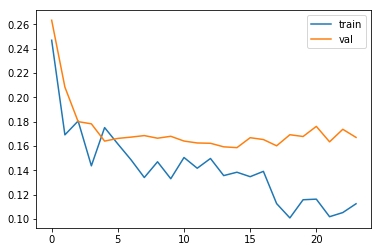

In [67]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train', 'val'])

In [239]:
preds = model(t_train_cat, t_train_cont)

In [240]:
torch.cat([preds, t_train_y.reshape(-1,1)], dim=1)[:10, :]

tensor([[219850.3906, 208500.0000],
        [188338.9219, 181500.0000],
        [219708.2500, 223500.0000],
        [181139.7812, 140000.0000],
        [318808.3125, 250000.0000],
        [145388.9219, 143000.0000],
        [270197.7500, 307000.0000],
        [214285.5938, 200000.0000],
        [130001.6172, 129900.0000],
        [127506.1016, 118000.0000]], grad_fn=<SliceBackward>)

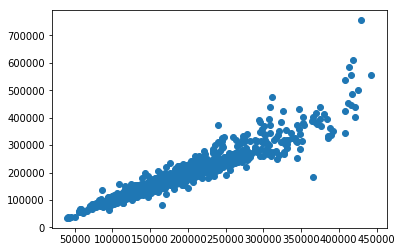

In [241]:
plt.scatter(preds.detach().cpu().numpy(), t_train_y.reshape(-1,1).detach().cpu())

In [242]:
# Convert all test data containers to tensors
t_test_cat = torch.tensor(df_test[cat_names].values, dtype=torch.long, device=device)
t_test_cont = torch.tensor(df_test[cont_names].values, dtype=torch.float32, device=device)

In [212]:
# Convert all test data containers to tensors
t_test_cat = torch.tensor(df_test[cat_names_selected].values, dtype=torch.long, device=device)
t_test_cont = torch.tensor(df_test[cont_names_selected].values, dtype=torch.float32, device=device)

In [243]:
with torch.no_grad():
    model.eval()
    preds_test = model(t_test_cat, t_test_cont)

In [244]:
out = 'submission.csv'
with open(PATH/out, 'w') as f:
    f.write('Id,SalePrice\n')
    for e, pred in enumerate(preds_test, start=1461):
        f.write(f'{e},{pred.item()}\n')

Score `0.14046`, rank #2705.

## Feature importance and selection

We will define a function that shuffles each column, calculates the loss, and records the impact on the loss function compared to no shuffling. The bigger the increase of the loss function after shuffling a particular variable, the bigger the predictive power of that variable.

In [245]:
cat_features = {e:feat for e, feat in enumerate(cat_names)}
cont_features = {e:feat for e, feat in enumerate(cont_names, start=len(cat_features))}

In [246]:
from numpy.random import RandomState

In [247]:
rs = RandomState()
rs.seed(0)
shuffle = rs.choice(range(len(df_train)), len(df_train), replace=False)

In [252]:
losses = {}
idx = torch.arange(df_train.shape[0]).long()

with torch.no_grad():
    model.eval()
    t_feat_cat = torch.tensor(df_train[cat_names].values, dtype=torch.long, device=device)
    t_feat_cont = torch.tensor(df_train[cont_names].values, dtype=torch.float32, device=device)
    t_feat_y = torch.tensor(df_train_y.values, dtype=torch.float32, device=device)
    loss = float(loss_fn(model(t_feat_cat, t_feat_cont), t_feat_y))
    
    for j in range(len(cat_names)):
        t_tmp_cat = t_feat_cat.clone()
        t_tmp_cat[idx, j] = t_feat_cat[shuffle, j]
        losses[cat_names[j]] = float(loss_fn(model(t_tmp_cat, t_feat_cont), t_feat_y))-loss
    
    for j in range(len(cont_names)):
        t_tmp_cont = t_feat_cont.clone()
        t_tmp_cont[idx, j] = t_feat_cont[shuffle, j]
        losses[cont_names[j]] = float(loss_fn(model(t_feat_cat, t_tmp_cont), t_feat_y))-loss
        
    #losses = sorted(losses.items(), key=lambda kv: kv[1], reverse=True)
    losses_relative = np.array(list(losses.values()))/loss*100
    feat_imp = pd.concat([
        pd.DataFrame(data=losses.values(), columns=['Absolute loss increase']),
        pd.DataFrame(data=losses_relative, columns=['Relative loss increase'])
    ], axis=1)
    
    index_names = {e: n for e, n in enumerate(losses.keys())}
    
    feat_imp.rename(index=index_names, inplace=True)

In [253]:
feat_imp.sort_values(by=['Relative loss increase'], ascending=False)

,Absolute loss increase,Relative loss increase
OverallQual,0.050061,42.319086
Neighborhood,0.029687,25.096076
GarageYrBlt,0.018451,15.597423
TotRmsAbvGrd,0.012177,10.293921
OverallCond,0.011351,9.595666
FullBath,0.007252,6.130551
KitchenQual,0.006650,5.621938
BsmtFinType1,0.006373,5.387213
Exterior1st,0.005927,5.010297
SaleType,0.005738,4.850364


In [189]:
bad_features = [feat for feat in feat_imp.index if feat_imp.loc[feat]['Relative loss increase'] <= 2.5]

In [190]:
cat_names_selected = [name for name in cat_names if name not in bad_features]
cont_names_selected = [name for name in cont_names if name not in bad_features]

In [191]:
# Convert all training data containers to tensors
t_train_cat = torch.tensor(df_train[:num_train][cat_names_selected].values, dtype=torch.long, device=device)
t_train_cont = torch.tensor(df_train[:num_train][cont_names_selected].values, dtype=torch.float32, device=device)
t_train_y = torch.tensor(df_train_y.values[:num_train], dtype=torch.float32, device=device)

# Convert all validation data containers to tensors
t_val_cat = torch.tensor(df_train[num_train:][cat_names_selected].values, dtype=torch.long, device=device)
t_val_cont = torch.tensor(df_train[num_train:][cont_names_selected].values, dtype=torch.float32, device=device)
t_val_y = torch.tensor(df_train_y.values[num_train:], dtype=torch.float32, device=device)

In [192]:
# Dataset
train_ds = TensorDataset(t_train_cat, t_train_cont, t_train_y)

In [198]:
# Dataloader
batch_size=128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [199]:
emb_dims = get_emb_dims(pd.concat([df_train[cat_names_selected], df_test[cat_names_selected]], axis=0, sort=False))

In [200]:
p_dropout = 0

In [201]:
# Instantiate the model
model = LinearNet(emb_dims=emb_dims, num_cont=len(cont_names_selected), p_dropout=p_dropout).to(device)

In [202]:
# Learning rate and optimizer
lr = 0.001
opt = torch.optim.Adam(model.parameters(), lr=lr)

(array([ 2.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  0.,  2.,  2.,  0.,  1.,  3.,  0.,  0.,  2.,  3.,
         8.,  8., 10., 10., 11.,  7.,  4., 11., 12.,  8., 19., 27., 18.,
        21., 19., 24., 43., 30., 45., 46., 40., 30., 36., 36., 32., 29.,
        44., 34., 35., 31., 26., 23., 23., 21., 23., 20., 27., 10., 20.,
        16., 14., 15., 11.,  4.,  8., 16., 13.,  5.,  9.,  3.,  3.,  6.,
         8.,  3.,  2.,  3.,  4.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([10.460242 , 10.490985 , 10.521727 , 10.552469 , 10.583212 ,
        10.613954 , 10.644696 , 10.675439 , 10.706181 , 10.736923 ,
        10.767666 , 10.798408 , 10.82915  , 10.859892 , 10.890635 ,
        10.921377 , 10.952119 , 10.9828615, 11.013604 , 11.044346 ,
        11.0750885, 11.105831 , 11.136573 , 11.1673155, 11.198058 ,
        11.2288   , 11.259542 , 11.290285 , 11.321027 , 11.351769 ,
        11.382511 , 11.413

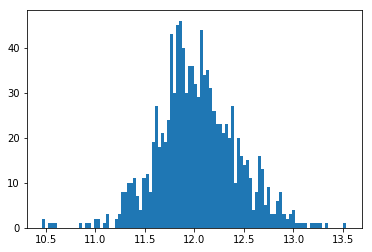

In [71]:
plt.hist(np.log(t_train_y.numpy()), bins=100, density=False)